In [2]:
from copy import deepcopy
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from types import SimpleNamespace
from functools import partial

import wandb
import torch, numpy as np
from minai.core import *
from minai.core import _get_preds
from fastprogress import progress_bar
from datasets import load_dataset
from torch import optim
from torch.utils.data import DataLoader
from torcheval.metrics import MulticlassAccuracy
from torch import nn, tensor
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, GenerationConfig

In [4]:
set_seed(42)

## Prepare

In [5]:
model_id = 'meta-llama/Llama-2-7b-hf'
# model_id = 'gpt2-medium'
m = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=0,
    # use_flash_attention_2=True,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,
    use_cache=False
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [7]:
# dataset_name = "cerebras/SlimPajama-627B"
# dataset_name = "roneneldan/TinyStories"
# dataset_name = "kaist-ai/CoT-Collection"
dataset_name = "togethercomputer/RedPajama-Data-1T-Sample"

In [54]:
dataset = load_dataset(dataset_name)

In [55]:
dataset = dataset["train"]
dataset

Dataset({
    features: ['text', 'meta'],
    num_rows: 930514
})

In [56]:
def tok(x):
    x = tokenizer(x['text'], padding='longest')
    x['labels'] = deepcopy(x['input_ids'])
    return x

In [57]:
dataset = dataset.shuffle(42).filter(lambda x:len(x['text'])<2048)

Filter:   0%|          | 0/930514 [00:00<?, ? examples/s]

In [58]:
dataset

Dataset({
    features: ['text', 'meta'],
    num_rows: 385944
})

In [59]:
N = len(dataset)
train_dataset = dataset.select(range(0,int(N*0.9))) # Subset for testing
eval_dataset = dataset.select(range(int(N*0.9), N)) # And only 200 eval samples

In [60]:
# train_dataset = dataset["train"] # Subset for testing
# eval_dataset = dataset["validation"] # And only 200 eval samples
# train_dataset

In [61]:
# Collate function for DataLoaders
def collate_fn(examples, debug=False):
    batch_size = len(examples)
    input_ids = tokenizer([e['text'] for e in examples], return_tensors='pt', padding=True)['input_ids']
    batch = (input_ids[:, :-1], input_ids[:, 1:]) # input_ids, labels
    # For HF style: batch = {'input_ids': input_ids[:, :-1], 'labels': input_ids[:, 1:]}
    return batch

In [62]:
batch_size = 16

In [63]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
)

In [64]:
len(train_dataloader)

21710

In [65]:
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
)

In [66]:
xb, yb = next(iter(train_dataloader))
xb.shape, yb.shape

(torch.Size([16, 566]), torch.Size([16, 566]))

In [67]:
tokenizer.decode(xb[0])[:250]

'<s> Most car fans are familiar with the fun arguments between Ford drivers and Chevy drivers, but they may not know about the battle between Ford and Ferrari. This short-lived battle existed in the 1960s and instead of being between the men and women'

In [68]:
tokenizer.decode(yb[0])[:250]

'Most car fans are familiar with the fun arguments between Ford drivers and Chevy drivers, but they may not know about the battle between Ford and Ferrari. This short-lived battle existed in the 1960s and instead of being between the men and women who'

## Testing

In [69]:
gen_config = GenerationConfig.from_pretrained(model_id)
test_config = SimpleNamespace(
    max_new_tokens=90,
    gen_config=gen_config)

In [70]:
gen_config

GenerationConfig {
  "bos_token_id": 1,
  "do_sample": true,
  "eos_token_id": 2,
  "max_length": 4096,
  "pad_token_id": 0,
  "temperature": 0.6,
  "top_p": 0.9,
  "transformers_version": "4.33.2"
}

In [71]:
prompts = [
    "We are in a world of ", 
    "The beauty of the lake comes from ", 
    "How is the planet ", 
    "Are you sure that we want to ",
    "There's a llama in my garden 😱 What should I do? Llamas are "
]

In [72]:
def generate(prompt, max_new_tokens, gen_config):
    with torch.inference_mode():
        tokenized_prompt = tokenizer(prompt, return_tensors='pt')['input_ids'].cuda()
        output = m.generate(tokenized_prompt, 
                            max_new_tokens=max_new_tokens, 
                            generation_config=gen_config)
    return tokenizer.decode(output[0][len(tokenized_prompt[0]):], skip_special_tokens=True)

In [73]:
def prompt_table(prompts, log=False):
    table = wandb.Table(columns=["prompt", "generation", "concat", "max_new_tokens", "temperature", "top_p"])
    for prompt in progress_bar(prompts):
        out = generate(prompt, test_config.max_new_tokens, test_config.gen_config)
        table.add_data(prompt, out, prompt+out, test_config.max_new_tokens, test_config.gen_config.temperature, test_config.gen_config.top_p)
    if log:
        wandb.log({"predictions":table})
    return table

In [74]:
table = prompt_table(prompts)

for row in table.data:
    print(f"- {row[2]}")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


- We are in a world of 7 billion people. We are 100% interconnected. Our world is becoming more interconnected every day. In the past, we were limited to a 50 mile radius. Now, we can communicate with people in the other side of the world. We can do it with the click of a button.
We have a lot of data. There are a lot of ways to collect data. We can collect data from the internet
- The beauty of the lake comes from 1,400 acres of clear water, 56,000 acres of wildlife and 20,000 acres of wetlands. Lake Lanier is a reservoir that was created in 1956 and is located in northern Georgia. It is the second largest lake in the state and the largest lake in the state that is entirely within Georgia. The lake is located on the Chattahooche
- How is the planet 2014?
In the year 2014, the planet Earth is in a state of disaster. The environment is polluted, and the resources are depleted. The human population is growing, and the world is becoming more and more crowded. The climate is changing, and 

In [75]:
class TableCB(Callback):
    "Log model predictions `log_every` steps"
    def __init__(self, log_every=1, prompts=prompts):
        self.log_every = log_every
        self.step = 0
        self.prompts = prompts
        
    def after_batch(self, learn):
        self.step += 1
        if self.step % self.log_every == 0:
            table = prompt_table(self.prompts, log=True)

## Training

In [76]:
dls = DataLoaders(train_dataloader, eval_dataloader)

In [77]:
def loss_fn(x, y):
    return torch.nn.functional.cross_entropy(x.view(-1, x.shape[-1]), y.view(-1))

In [78]:
# from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

# peft_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM, inference_mode=False, r=32, lora_alpha=16, lora_dropout=0.1,
#     target_modules=[l+"_proj" for l in ["k", 'v', "q", "o", "gate", "up", "down"]]
# )
# m = get_peft_model(m, peft_config)

In [79]:
class HFMetricsCB(MetricsCB):
    "Fix Metrics to work with HF models!"
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): 
            preds = _get_preds(learn.preds, learn.preds_nm) # torcheval is not compatible with dicts
            classes = preds.shape[-1]  #torcheval wants flatten tensors
            m.update(to_cpu(preds).view(-1, classes), y.view(-1))
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [80]:
class WandbCB(Callback):
    "Hacky W&B callback"
    order = MetricsCB.order+1
    def __init__(self, model_name=None): 
        self.model_name = model_name
        self.step = 0
    def before_fit(self, learn):
        if wandb.run is None:
            raise Exception("You have to run fit inside a wandb run")
    
    def after_batch(self, learn):
        self.step += 1
        m =  {k:v.compute().item() for k,v in learn.metrics.all_metrics.items()}
        if learn.training:
            m["step"] = self.step
            m["train_loss"] = m["loss"]
        else: m["val_loss"] = m["loss"]
        m.pop("loss", None)
        wandb.log(m)
    
    def after_fit(self, learn):
        if self.model_name is not None:
            model_name = f"{wandb.run.id}_{self.model_name}"
            at = wandb.Artifact(model_name, type="model")
            torch.save(learn.model.state_dict(), f"models/{self.model_name}.pth")
            at.add_file(f"models/{self.model_name}.pth")
            wandb.log_artifact(at)

In [81]:
prog = ProgressCB(plot=True)
cbs = [DeviceCB(), 
       HFMetricsCB(accuracy=MulticlassAccuracy(num_classes=tokenizer.vocab_size))]

In [82]:
# Just freeze embeddings for small memory decrease
m.model.embed_tokens.weight.requires_grad_(False);

## Train

optimizer

In [83]:
def split_and_freeze(model, n_cut=None, n_freeze=0):
    "Cut a model up to `n_cut` and freeze layers up to `n_freeze`"
    model.model.layers = m.model.layers[:n_cut]

    # freeze layers (disable gradients)
    for param in model.parameters(): param.requires_grad = False
    for param in model.lm_head.parameters(): param.requires_grad = True
    for param in model.model.layers[n_freeze:].parameters(): param.requires_grad = True

    return model 

Freezing everything besides the head

In [84]:
n_cut = 32
n_freeze = 24

In [85]:
m = split_and_freeze(m, n_cut, n_freeze)

In [86]:
optim = partial(torch.optim.Adam, betas=(0.9,0.99), eps=1e-5)

In [87]:
lr = 1e-3
sz = len(dls.train)//50

In [88]:
learn = MomentumLearner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs, preds_nm='logits', epoch_sz=sz, mom=0.9)

In [89]:
params = sum([p.numel() for p in m.parameters()])/1_000_000
trainable_params = sum([p.numel() for p in m.parameters() if p.requires_grad])/1_000_000
print(f"Total params: {params:.2f}M, Trainable: {trainable_params:.2f}M")

Total params: 6738.42M, Trainable: 1750.14M


In [90]:
m.gradient_checkpointing_enable()

In [91]:
# NB lr_find does *not* reset model, so recreate it afterwards
# learn.lr_find(max_mult=10)

In [92]:
config = SimpleNamespace(
    model_id=model_id,
    dataset_name=dataset_name,
    n_cut=n_cut,
    n_freeze=n_freeze,
    lr=lr,
    epoch_sz=sz,
    mom=0.9,
    total_params=params,
    trainable_params=trainable_params,
)

In [93]:
wandb.init(project="miniai_llm", entity="fastai", config=config, tags=["7b"])

accuracy,▁▅▆▆▇▇▇▇▇▇▇█████████████████████████████
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.7704
step,160
train_loss,1.20268


/opt/conda/envs/pt/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


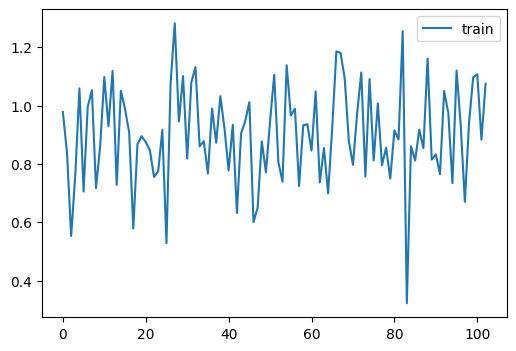

In [ ]:
learn.fit(1, cbs=[prog, WandbCB(), TableCB(log_every=1000)])

In [ ]:
wandb.finish()

## Deeper Cut and FT

In [ ]:
def param_count(m):
    params = sum([p.numel() for p in m.parameters()])/1_000_000
    trainable_params = sum([p.numel() for p in m.parameters() if p.requires_grad])/1_000_000
    print(f"Total params: {params:.2f}M, Trainable: {trainable_params:.2f}M")
    return params, trainable_params

In [ ]:
def cut_and_train(m, config, tags=None):
    m = split_and_freeze(m, config.n_cut, config.n_freeze)
    
    optim = partial(torch.optim.Adam, betas=(0.9,0.99), eps=1e-5)
    
    lr = config.lr
    sz = len(dls.train)//50
    prog = ProgressCB(plot=True)
    cbs = [DeviceCB(), HFMetricsCB(accuracy=MulticlassAccuracy(num_classes=tokenizer.vocab_size))]
    learn = MomentumLearner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs, preds_nm='logits', epoch_sz=sz, mom=0.9)
    
    config.total_params, config.trainable_params = param_count(m)
    m.gradient_checkpointing_enable()
    
    with wandb.init(project="miniai_llm", entity="fastai", config=config, tags=tags):
        learn.fit(1, cbs=[prog, WandbCB(), TableCB(log_every=1000)])

In [ ]:
config.n_cut = 24  # no cutting, same as None or 32
config.n_freeze = 16

cut_and_train(m, config, tags=["5B"])

In [ ]:
config.n_cut = 16  # no cutting, same as None or 32
config.n_freeze = 8

cut_and_train(m, config, tags=["5B"])

In [ ]:
config.n_cut = 8  # no cutting, same as None or 32
config.n_freeze = 4

cut_and_train(m, config, tags=["1.75B"])